In [118]:
# General
import numpy
import os

# Processing
import pandas as pd

# Drawing
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.cm import get_cmap
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Processing Data

In [119]:
# Data from: https://www.scotland.police.uk/about-us/covid-19-police-scotland-response/enforcement-and-response-data/

raw_data = pd.read_excel(os.path.join(os.getcwd(), 'datasets', 'coronavirus-enforcement-information-to-9-june-2021.xlsx'), sheet_name=1)
raw_data.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'], axis=1, inplace=True)
raw_data.head()

,Date,Division Letter,SD Letter,Area Commands,Asked / Informed,Warned / Instructed,Removed from Place or Premises,FPN,Arrested
0,2020-03-27,A,AE,Moray,3,1,0,0,0
1,2020-03-27,G,GA,Glasgow South West,17,0,0,0,0
2,2020-03-27,J,JB,Scottish Borders,2,2,0,0,0
3,2020-03-27,L,LA,West Dumbartonshire,12,0,1,1,0
4,2020-03-27,N,NaN,Inverness,1,0,0,0,0


In [120]:
# Taking account of NaNs
# Explanation:
# The xlsx to pandas dataframe conversion seems to have taken "NA" for a division "N" and an Area Command "Inverness"
# and interpret that "NA" as actually: "NaN". Which is very annoying. So the below overwrites the SD letter of area commands
# that are inverness and turns them back to "NA"
raw_data.loc[raw_data["Area Commands"] == "Inverness", "SD Letter"] = raw_data["SD Letter"].fillna("NA")

In [121]:
if (raw_data.isnull().sum().sum() != 0):
    raise ValueError("We have NaNs in our dataframe")


## Group by Division - across all time

In [122]:
division_grouped = raw_data.groupby('Division Letter', as_index=False
                                ).agg(
                                {"Asked / Informed": "sum",
                                "Warned / Instructed": "sum",
                                "Removed from Place or Premises": "sum",
                                "FPN": "sum",
                                "Arrested": "sum",
                                })

## Find Population by Division

In [123]:
# Data from: https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019

raw_pop_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'Population', 'mid-year-pop-est-19-data_Table 2.csv'))
# Keep only the specific columns
raw_pop_data = raw_pop_data[['Unnamed: 1','Unnamed: 2']]
# Rename them inplace
raw_pop_data.rename(columns={'Unnamed: 1': 'Council areas', 'Unnamed: 2': 'Population'}, inplace=True)
# Drop upper rows that are bad
raw_pop_data = raw_pop_data.drop(raw_pop_data.index[[0,1,2,3,4]]).reset_index(drop=True)
# Drop from certain row, minus 1 for the row above position
raw_pop_data = raw_pop_data[:(raw_pop_data[raw_pop_data['Council areas'] == 'NHS Board areas'].index[0] - 1)]
# Strip out all the commas in Objects of the Population column
raw_pop_data["Population"].replace(',','', regex=True, inplace=True)
# Convert string to int
raw_pop_data["Population"] = raw_pop_data["Population"].astype(str).astype(int)

In [124]:
# We group the council areas into our police divisions
# First, set our index
raw_pop_data.set_index('Council areas')
# Create our division dictionary
div_dict = {'A': ["Moray", "Aberdeenshire", "Aberdeen City"],
            'C': ["Stirling", "Clackmannanshire", "Falkirk"],
            'D': ["Angus", "Dundee City", "Perth and Kinross"],
            'E': ["City of Edinburgh"],
            'G': ["East Renfrewshire", "Glasgow City", "East Dunbartonshire"],
            'J': ["Scottish Borders", "East Lothian", "Midlothian", "West Lothian"],
            'K': ["Inverclyde", "Renfrewshire"],
            'L': ["Argyll and Bute", "West Dunbartonshire"],
            'N': ["Na h-Eileanan Siar", "Orkney Islands", "Highland", "Shetland Islands"],
            'P': ["Fife"],
            'Q': ["South Lanarkshire", "North Lanarkshire"],
            'U': ["South Ayrshire", "East Ayrshire", "North Ayrshire"],
            'V': ["Dumfries and Galloway"]
            }

div_pop = {}

def divisionPopulation(row):
    incomingRow = row.tolist()
    #print(incomingRow)

    for div, councils in div_dict.items():
        for council in councils:
            if (council == incomingRow[0]):
                #print(div)
                if div in div_pop:
                    div_pop[div] += incomingRow[1]
                else:
                    div_pop[div] = incomingRow[1]

raw_pop_data.apply(lambda row: divisionPopulation(row), axis=1)

div_pop_data = pd.DataFrame(div_pop.items(), columns=['Division Letter', 'Population'])

In [125]:
division_data = pd.merge(division_grouped, div_pop_data, on='Division Letter')

division_data['Asked / Informed per 100k'] = division_data.apply (lambda row: row['Asked / Informed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Warned / Instructed per 100k'] = division_data.apply (lambda row: row['Warned / Instructed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Removed from Place or Premises per 100k'] = division_data.apply (lambda row: row['Removed from Place or Premises']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['FPN per 100k'] = division_data.apply (lambda row: row['FPN']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Arrested per 100k'] = division_data.apply (lambda row: row['Arrested']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data.head(15)

,Division Letter,Asked / Informed,Warned / Instructed,Removed from Place or Premises,FPN,Arrested,Population,Asked / Informed per 100k,Warned / Instructed per 100k,Removed from Place or Premises per 100k,FPN per 100k,Arrested per 100k
0,A,3462,1259,217,426,44,585700,591.087588,214.956462,37.049684,72.733481,7.512378
1,C,6474,1700,238,821,80,306640,2111.270545,554.396034,77.615445,267.740673,26.089225
2,D,3860,934,205,672,33,417470,924.617338,223.728651,49.105325,160.969651,7.904760
3,E,13285,5434,1351,2320,84,524930,2530.813632,1035.185644,257.367649,441.963690,16.002134
4,G,24897,8163,1041,5751,210,837290,2973.521719,974.931027,124.329683,686.858794,25.080916
5,J,4278,1123,198,453,31,498160,858.760238,225.429581,39.746266,90.934639,6.222900
6,K,5034,1689,137,1293,65,256900,1959.517322,657.454262,53.328143,503.308680,25.301674
7,L,7875,1665,87,1001,45,174800,4505.148741,952.517162,49.771167,572.654462,25.743707
8,N,5135,1327,70,429,39,307740,1668.616364,431.208163,22.746474,139.403392,12.673036
9,P,6277,1110,291,808,103,373550,1680.364074,297.148976,77.901218,216.303038,27.573283


# Drawing Data

/home/callum/.conda/envs/MAIN/lib/python3.9/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


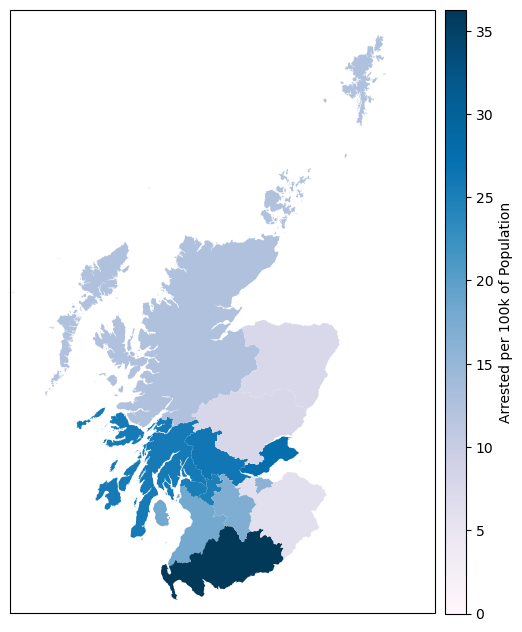

In [126]:
# Creating new figure and axes instances
def enforcementOutcome(outcome_type):
    fig = plt.figure(figsize=(6,8), dpi=100)
    projectionPARAM = ccrs.TransverseMercator(central_longitude=-2.0, central_latitude=49.0, false_easting=400000.0, false_northing=-100000.0, scale_factor=0.9996012717, approx=False)
    ax = fig.add_subplot(1, 1, 1, projection=projectionPARAM)
    ax.set_extent([-8, 0, 54.5, 61]) # Ideal coordinate map range for plotting Scotland

    police_dict = (division_data[['Division Letter', outcome_type]].set_index('Division Letter').T.to_dict('r'))[0]

    # Downloaded from: https://spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=61F713CF39B3EE2F440F48E9C31BA806#/metadata/4364af71-167a-4236-b5a0-bd4109913231
    area_file = os.path.join(os.getcwd(), 'datasets', 'ScottishPoliceDivisions', 'SG_ScottishPoliceDivisions_2019.shp')
    police_divisions = shapereader.Reader(area_file)

    norm = colors.Normalize(vmin=0., vmax=max(police_dict.values()))
    cmap = get_cmap('PuBu')

    for record in police_divisions.records():
        code = record.attributes['AdminCode']
        police_entry = police_dict.get(code, -1)
        if police_entry == -1:
            police_color = "Silver"
        else:
            police_color = cmap(police_entry/max(police_dict.values()))
        ax.add_geometries(
                [record.geometry],
                #facecolor=numpy.random.rand(3,),
                facecolor=police_color,
                linewidth=0,
                crs=projectionPARAM,
        )

    # following https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes
    # we need to set axes_class=plt.Axes, else it attempts to create
    # a GeoAxes as colorbar

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

    fig.add_axes(ax_cb)

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cb = plt.colorbar(sm, cax=ax_cb)
    cb.set_label(outcome_type + " of Population")

    plt.plot()

enforcementOutcome('Arrested per 100k')

###
# Copyright Scottish Government, contains Ordnance Survey data © Crown copyright and database right (2021)
###